<a href="https://colab.research.google.com/github/gaborvecsei/Stocks-Pattern-Analyzer/blob/master/Time_Series_Matcher_KDTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance &> /dev/null

In [2]:
import numpy as np
import yfinance
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from sklearn.neighbors import KDTree
import requests
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def normalize(x, axis=0):
    # If axis=0 then columns are normalized, if it is 1 then rows
    return (x - np.min(x, axis=axis)) / np.ptp(x, axis=axis)

In [4]:
API_KEY = "I9X80RO2LINPEY7L"

In [5]:
def get_daily_stock_df(ticker):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey={API_KEY}&datatype=csv&outputsize=full"
    return pd.read_csv(url)


def get_extended_stock_df(ticker, interval="60min", nb_months_of_data:int=1):
    assert interval in ["1min", "5min", "15min", "30min", "60min"]

    url_template = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={ticker}&interval={interval}&apikey={API_KEY}&slice={slice_}"

    slices = [f"year{y}month{m}" for m in range(1, 13) for y in range(1, 3)]
    if nb_months_of_data is not None:
        slices = slices[:nb_months_of_data]

    merged_df = None

    for s in slices:
        url = url_template.format(ticker=ticker, interval=interval, API_KEY=API_KEY, slice_=s)
        df = pd.read_csv(url)

        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.concat((merged_df, df))
    merged_df.set_index("time", inplace=True)
    # merged_df.index = pd.to_datetime(merged_df.index)
    return merged_df

# Preparation

In [120]:
STOCK_TICKERS = ["AAPL", "MSFT", "AMZN", "BABA", "ROKU", "TDOC", "CRSP", "SQ", "NVTA", "Z", "BIDU", "SPOT", "PRLB", "TSLA", "GME", "BB", "AMC", "LI", "NIO"]
WINDOW_SIZE = 14

TODO: solve how to serialize these for multiple window sizes

In [121]:
# Max number of windows = number of years * days in a year * number of tickers
max_values_per_stock = 5 * 365
max_nb_windows = (max_values_per_stock * len(STOCK_TICKERS))

# This holds the original values
ticker_originals = np.zeros((len(STOCK_TICKERS), max_values_per_stock), dtype=np.float16)
# This holds the normalized values of the selected window from a stock
ticker_windows = np.zeros((max_nb_windows, WINDOW_SIZE), dtype=np.float16)
# This holds the start and end indices from a dataframe
ticker_window_indices = np.zeros((max_nb_windows, 2), dtype=np.uint16)
# Here we store the windows start and end dates
ticker_window_dates = []
# This holds which ticker the window belongs to (ticker is encoded with it's index in the list)
window_labels = np.zeros(max_nb_windows, dtype=np.uint8)
# As we are pre-allocating arrays, with this we can crop the unnecessary part which does not contain data 
useful_data_mask = np.zeros(max_nb_windows, dtype=bool)
# This dict will hold the label to ticker mapping
ticker_to_label = {}

TODO: make this run in parallel for the different stocks

In [122]:
row = 0

for ticker_label, t in enumerate(tqdm(STOCK_TICKERS)):
    # Df is reversed so the most recent values are at the top
    ticker_df = yfinance.Ticker(t).history(period="5y", interval="1d")[::-1]
    close_values = ticker_df["Close"].values

    # ticker_df = get_extended_stock_df(t, "60min", nb_months_of_data=3)
    # close_values = ticker_df["close"].values
    
    ticker_originals[ticker_label, :len(close_values)] = close_values
    ticker_to_label[t] = ticker_label
    
    for i in range(0, len(ticker_df)-WINDOW_SIZE, 1):
        start_index = i
        end_index = i + WINDOW_SIZE
        norm_values = normalize(close_values[start_index:end_index])
        start_date = ticker_df.index.values[start_index]
        end_date = ticker_df.index.values[end_index]

        ticker_window_indices[row, :] = [start_index, end_index]
        ticker_window_dates.append([start_date, end_date])
        ticker_windows[row, :] = norm_values
        window_labels[row] = ticker_label
        useful_data_mask[row] = 1
        row += 1

100%|██████████| 19/19 [00:03<00:00,  6.29it/s]


In [123]:
ticker_windows = ticker_windows[useful_data_mask]
window_labels = window_labels[useful_data_mask]
ticker_window_indices = ticker_window_indices[useful_data_mask]
ticker_window_dates = np.array(ticker_window_dates)

In [124]:
label_to_ticker = {v:k for k, v in ticker_to_label.items()}

In [125]:
ticker_windows.shape

(20740, 14)

# KDTree

In [126]:
kdtree = KDTree(ticker_windows)

In [139]:
anchor_ticker = "AAPL"
anchor_ticker_mask = window_labels == ticker_to_label[anchor_ticker]
anchor_windows = ticker_windows[anchor_ticker_mask]

In [140]:
anchor_values_norm = anchor_windows[0, :]

anchor_start_date, anchor_end_date = ticker_window_dates[anchor_ticker_mask][0]
anchor_start_date = pd.to_datetime(str(anchor_start_date)).strftime("%Y.%m.%d")
anchor_end_date = pd.to_datetime(str(anchor_end_date)).strftime("%Y.%m.%d")

In [141]:
top_K_distances, top_K_indices = kdtree.query(anchor_values_norm.reshape(1, -1), k=10)
top_K_distances = top_K_distances.ravel()[1:]
top_K_indices = top_K_indices.ravel()[1:]

TODO: This code is terrible, make it much more clear

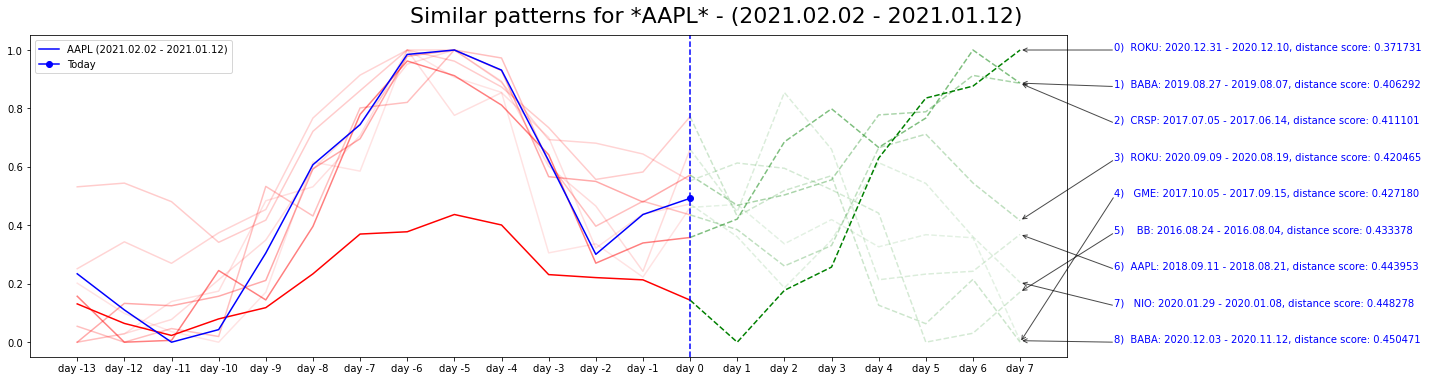

In [142]:
FUTURE_WINDOW = 7
fig, ax0 = plt.subplots(1, 1, figsize=(20, 5))

for ii, (i, dist) in enumerate(zip(top_K_indices, top_K_distances)):
    ticker_label = window_labels[i]
    ticker = label_to_ticker[ticker_label]
    start, end = ticker_window_indices[i]
    start_date, end_date = ticker_window_dates[i]

    start_date = pd.to_datetime(str(start_date)).strftime("%Y.%m.%d")
    end_date = pd.to_datetime(str(end_date)).strftime("%Y.%m.%d")

    start -= FUTURE_WINDOW
    if start < 0:
        start = 0

    vals_norm = normalize(ticker_originals[ticker_label][start:end])[::-1]
    x_vals = np.arange(len(vals_norm))
    x_labels = [f"day {i+1}" for i in (x_vals-WINDOW_SIZE)]

    alpha = (1/(ii+1))
    ax0.plot(x_vals[:WINDOW_SIZE], vals_norm[:WINDOW_SIZE], color="r", alpha=alpha)
    ax0.plot(x_vals[WINDOW_SIZE-1:], vals_norm[WINDOW_SIZE-1:], color="g", alpha=alpha, linestyle="--")

    text = f"{ii}) {label_to_ticker[ticker_label]:>5}: {start_date} - {end_date}, distance score: {dist:3f}"
    ax0.text(x_vals[-1]+2, 1-np.linspace(0, 1, len(top_K_indices))[ii], text, color="b")

    ax0.annotate("", xy=(x_vals[-1], vals_norm[WINDOW_SIZE-1:][-1]),
                 xytext=(x_vals[-1]+2, 1-np.linspace(0, 1, len(top_K_indices))[ii]), arrowprops=dict(arrowstyle="->", alpha=0.7))

ax0.plot(anchor_values_norm[::-1], label=f"{anchor_ticker} ({anchor_start_date} - {anchor_end_date})", color="blue")
ax0.plot(WINDOW_SIZE-1, anchor_values_norm[::-1][-1], color="blue", marker="o", label="Today")
ax0.set_xticks(x_vals)
ax0.set_xticklabels(x_labels)
ax0.legend()
ax0.axvline(WINDOW_SIZE-1, linestyle="--", color="b")

fig.suptitle(f"Similar patterns for *{anchor_ticker}* - ({anchor_start_date} - {anchor_end_date})", size=22, y=1.05)
fig.tight_layout()